In [ ]:
# Training with Improved Configuration
# Key changes: ResNet34, Reduced MixUp (alpha=0.2), Simplified augmentation, 100 epochs

optimizer_v2 = optim.SGD(model_v2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS_V2 = 100

scheduler_v2 = OneCycleLR(
    optimizer_v2,
    max_lr=0.05,
    steps_per_epoch=len(train_loader_v2),
    epochs=EPOCHS_V2
)

print("=" * 70)
print("Training Configuration:")
print("=" * 70)
print(f"Model: ResNet34 (21.3M parameters)")
print(f"MixUp Alpha: 0.2 (reduced from 0.4)")
print(f"Epochs: {EPOCHS_V2}")
print(f"Optimizer: SGD (lr=0.01, momentum=0.9, weight_decay=1e-4)")
print(f"Scheduler: OneCycleLR (max_lr=0.05)")
print(f"Data Augmentation: Simplified (removed redundant color transforms)")
print("=" * 70)
print()

best_acc = 0.0
for epoch in range(1, EPOCHS_V2 + 1):
    train(model_v2, device, train_loader_v2, optimizer_v2, scheduler_v2, epoch, use_mixup=True, mixup_alpha=0.2)
    acc = test(model_v2, device, test_loader)
    
    if acc > best_acc:
        best_acc = acc
        print(f"*** New best accuracy: {best_acc:.2f}% ***")
    
    # Early stopping if target reached
    if acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {acc:.2f}%")
        print(f"{'=' * 70}")
        break

print(f"\nTraining completed. Best test accuracy: {best_acc:.2f}%")

In [ ]:
from torchvision.models import resnet34

# Initialize ResNet34 for CIFAR-100
model_v2 = resnet34(weights=None, num_classes=100).to(device)

print("=" * 70)
print("Model Upgrade: ResNet18 → ResNet34")
print("=" * 70)
summary(model_v2, input_size=(3, 32, 32))

In [ ]:
# Simplified Data Augmentation (Removed redundant color transforms)
class SimplifiedAlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=(-7, 7), p=0.5),
            A.RandomCrop(height=28, width=28, p=0.5),
            A.Resize(height=32, width=32),
            A.CoarseDropout(
                max_holes=1,
                max_height=16, max_width=16,
                fill_value=tuple(int(m * 255) for m in mean),
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Create new datasets with simplified augmentations
train_transforms_v2 = SimplifiedAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)
train_dataset_v2 = datasets.CIFAR100(root='./data', train=True, download=False, transform=train_transforms_v2)
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

print("Simplified augmentation pipeline created!")
print("Removed: ColorJitter, RandomBrightnessContrast, HueSaturationValue")
print("Kept: HorizontalFlip, Affine, RandomCrop, CoarseDropout")

# Import Libraries

In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# CIFAR-100 Mean and Std
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2761)

# Custom Albumentations Transform Wrapper
class AlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=(-7, 7), p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
            A.RandomCrop(height=28, width=28, p=0.5),
            A.Resize(height=32, width=32),
            A.CoarseDropout(
                max_holes=1,
                max_height=16, max_width=16,
                fill_value=tuple(int(m * 255) for m in mean),  # Convert mean to 0-255
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Instantiate transforms
train_transforms = AlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])

# CIFAR-100 Dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=5, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=5, pin_memory=True)


/tmp/ipython-input-2120757611.py:24: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
100%|██████████| 169M/169M [00:32<00:00, 5.21MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


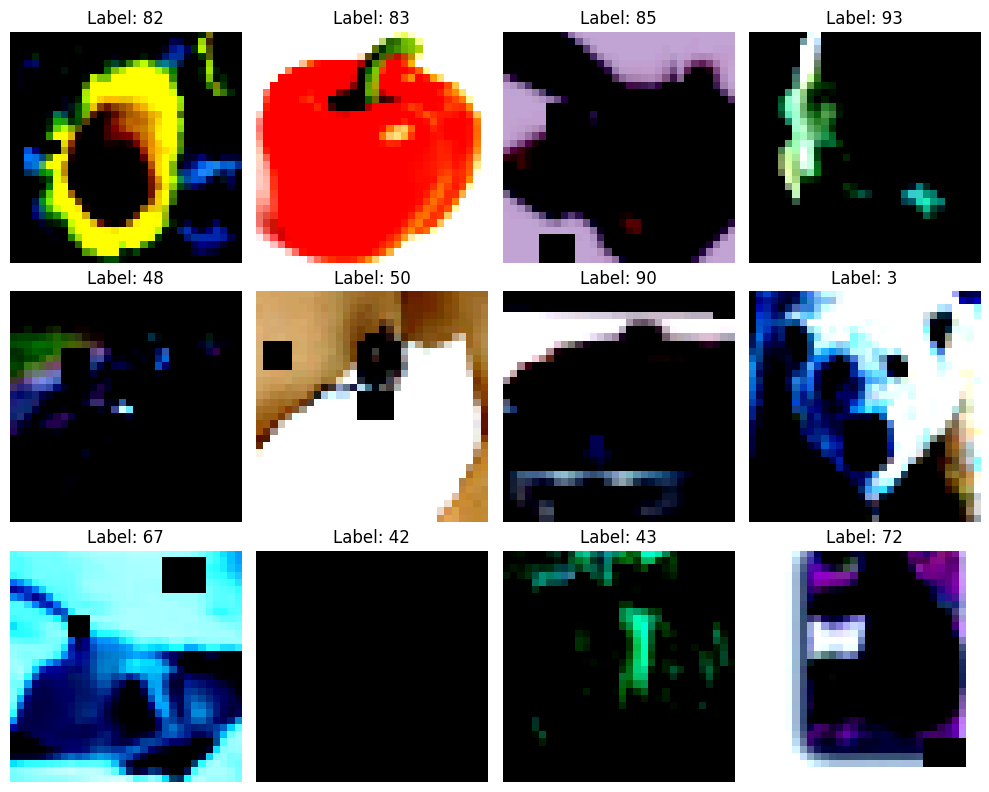

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get a batch
batch_data, batch_label = next(iter(train_loader))

# Move to CPU and detach the computation graph
batch_data = batch_data.cpu().detach()

fig = plt.figure(figsize=(10, 8))

for i in range(12):
    img = batch_data[i]  # shape: [3, 32, 32]
    img = img.numpy().transpose((1, 2, 0))  # to shape [32, 32, 3]
    img = np.clip(img, 0, 1)  # ensure valid range for display

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {batch_label[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchsummary import summary

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load ResNet18 without pretrained weights
model = resnet18(weights=None, num_classes=100).to(device)

# Modify the final fully connected layer for CIFAR-100 (100 classes)
model.fc = nn.Linear(model.fc.in_features, 100)

# Move model to device
model = model.to(device)

# Print the summary (for CIFAR-100 input size)
summary(model, input_size=(3, 32, 32))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14      

In [4]:
def mixup_data(x, y, alpha=1.0, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import torch.nn.functional as F


# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True, mixup_alpha=0.4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
            outputs = model(inputs)
            loss = lam * F.cross_entropy(outputs, targets_a) + (1 - lam) * F.cross_entropy(outputs, targets_b)
        else:
            outputs = model(data)
            loss = F.cross_entropy(outputs, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accuracy tracking (still approximate when using MixUp)
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)

        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS = 40

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

Epoch 1 Loss=3.4221 Acc=14.92: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]



Test set: Average loss: 3.2998, Accuracy: 2028/10000 (20.28%)



Epoch 2 Loss=3.4910 Acc=18.87: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]



Test set: Average loss: 3.1236, Accuracy: 2349/10000 (23.49%)



Epoch 3 Loss=3.3535 Acc=22.10: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s]



Test set: Average loss: 3.0261, Accuracy: 2502/10000 (25.02%)



Epoch 4 Loss=3.2286 Acc=24.60: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 2.9580, Accuracy: 2744/10000 (27.44%)



Epoch 5 Loss=2.6924 Acc=27.50: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]



Test set: Average loss: 2.7870, Accuracy: 2991/10000 (29.91%)



Epoch 6 Loss=2.7445 Acc=30.46: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]



Test set: Average loss: 2.6035, Accuracy: 3402/10000 (34.02%)



Epoch 7 Loss=2.4460 Acc=32.97: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]



Test set: Average loss: 2.4771, Accuracy: 3616/10000 (36.16%)



Epoch 8 Loss=2.3339 Acc=35.59: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]



Test set: Average loss: 2.3704, Accuracy: 3859/10000 (38.59%)



Epoch 9 Loss=2.5520 Acc=38.20: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]



Test set: Average loss: 2.3657, Accuracy: 3872/10000 (38.72%)



Epoch 10 Loss=2.2250 Acc=40.52: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]



Test set: Average loss: 2.2985, Accuracy: 4087/10000 (40.87%)



Epoch 11 Loss=2.3408 Acc=42.45: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]



Test set: Average loss: 2.1994, Accuracy: 4266/10000 (42.66%)



Epoch 12 Loss=2.0510 Acc=44.70: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]



Test set: Average loss: 2.1202, Accuracy: 4453/10000 (44.53%)



Epoch 13 Loss=2.1098 Acc=46.50: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s]



Test set: Average loss: 2.1382, Accuracy: 4423/10000 (44.23%)



Epoch 14 Loss=2.0236 Acc=48.29: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s]



Test set: Average loss: 2.1053, Accuracy: 4550/10000 (45.50%)



Epoch 15 Loss=1.8044 Acc=49.52:  64%|██████▍   | 251/391 [00:20<00:11, 12.30it/s]


KeyboardInterrupt: 

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import torch.nn.functional as F


# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True, mixup_alpha=0.4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
            outputs = model(inputs)
            loss = lam * F.cross_entropy(outputs, targets_a) + (1 - lam) * F.cross_entropy(outputs, targets_b)
        else:
            outputs = model(data)
            loss = F.cross_entropy(outputs, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accuracy tracking (still approximate when using MixUp)
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)

        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS = 40

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

Epoch 1 Loss=4.1080 Acc=4.93: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 3.8700, Accuracy: 1146/10000 (11.46%)



Epoch 2 Loss=3.7708 Acc=8.33: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 3.6858, Accuracy: 1371/10000 (13.71%)



Epoch 3 Loss=3.8650 Acc=10.80: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 3.4331, Accuracy: 1931/10000 (19.31%)



Epoch 4 Loss=3.4393 Acc=13.67: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 3.2391, Accuracy: 2208/10000 (22.08%)



Epoch 5 Loss=3.2511 Acc=15.54: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]



Test set: Average loss: 3.0029, Accuracy: 2696/10000 (26.96%)



Epoch 6 Loss=4.1449 Acc=17.31: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 3.1769, Accuracy: 2445/10000 (24.45%)



Epoch 7 Loss=3.7653 Acc=19.57: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 2.9067, Accuracy: 2835/10000 (28.35%)



Epoch 8 Loss=2.9900 Acc=21.15: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 2.7548, Accuracy: 3121/10000 (31.21%)



Epoch 9 Loss=3.0817 Acc=23.03: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]



Test set: Average loss: 2.6914, Accuracy: 3391/10000 (33.91%)



Epoch 10 Loss=3.1194 Acc=24.09: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 2.6683, Accuracy: 3266/10000 (32.66%)



Epoch 11 Loss=2.6397 Acc=25.52: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 2.5892, Accuracy: 3535/10000 (35.35%)



Epoch 12 Loss=3.4141 Acc=27.16: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 2.5892, Accuracy: 3435/10000 (34.35%)



Epoch 13 Loss=3.0038 Acc=28.26: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 2.5131, Accuracy: 3670/10000 (36.70%)



Epoch 14 Loss=2.5250 Acc=30.06: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 2.4048, Accuracy: 3911/10000 (39.11%)



Epoch 15 Loss=3.3204 Acc=29.31: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s]



Test set: Average loss: 2.3810, Accuracy: 3953/10000 (39.53%)



Epoch 16 Loss=2.6870 Acc=31.37: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 2.2785, Accuracy: 4209/10000 (42.09%)



Epoch 17 Loss=2.0350 Acc=32.29: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]



Test set: Average loss: 2.2638, Accuracy: 4195/10000 (41.95%)



Epoch 18 Loss=3.5353 Acc=31.85: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s]



Test set: Average loss: 2.2711, Accuracy: 4211/10000 (42.11%)



Epoch 19 Loss=2.3673 Acc=34.05: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 2.2630, Accuracy: 4185/10000 (41.85%)



Epoch 20 Loss=2.4790 Acc=35.21: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]



Test set: Average loss: 2.2004, Accuracy: 4419/10000 (44.19%)



Epoch 21 Loss=2.1419 Acc=34.65: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 2.1757, Accuracy: 4424/10000 (44.24%)



Epoch 22 Loss=2.7917 Acc=36.62: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 2.1677, Accuracy: 4446/10000 (44.46%)



Epoch 23 Loss=2.2937 Acc=36.55: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 2.1410, Accuracy: 4523/10000 (45.23%)



Epoch 24 Loss=3.8063 Acc=37.75: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 2.1330, Accuracy: 4539/10000 (45.39%)



Epoch 25 Loss=2.1359 Acc=38.65: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 2.0854, Accuracy: 4642/10000 (46.42%)



Epoch 26 Loss=2.4483 Acc=39.53: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]



Test set: Average loss: 2.0427, Accuracy: 4759/10000 (47.59%)



Epoch 27 Loss=3.5080 Acc=39.19: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 2.0551, Accuracy: 4742/10000 (47.42%)



Epoch 28 Loss=3.5178 Acc=41.78: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 1.9689, Accuracy: 4921/10000 (49.21%)



Epoch 29 Loss=2.9985 Acc=42.47: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 2.0152, Accuracy: 4847/10000 (48.47%)



Epoch 30 Loss=2.8367 Acc=43.20: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 1.9498, Accuracy: 4943/10000 (49.43%)



Epoch 31 Loss=2.3514 Acc=42.87: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 2.0660, Accuracy: 4857/10000 (48.57%)



Epoch 32 Loss=1.5283 Acc=45.01: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 1.9240, Accuracy: 5052/10000 (50.52%)



Epoch 33 Loss=1.6636 Acc=47.21: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 1.9262, Accuracy: 5089/10000 (50.89%)



Epoch 34 Loss=2.5289 Acc=45.95: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 1.8795, Accuracy: 5163/10000 (51.63%)



Epoch 35 Loss=3.3824 Acc=48.72: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]



Test set: Average loss: 1.8244, Accuracy: 5267/10000 (52.67%)



Epoch 36 Loss=3.0239 Acc=50.60: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 1.8451, Accuracy: 5234/10000 (52.34%)



Epoch 37 Loss=2.1382 Acc=52.40: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]



Test set: Average loss: 1.8164, Accuracy: 5307/10000 (53.07%)



Epoch 38 Loss=1.9740 Acc=53.36: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 1.7984, Accuracy: 5315/10000 (53.15%)



Epoch 39 Loss=3.7840 Acc=52.19: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]



Test set: Average loss: 1.8411, Accuracy: 5287/10000 (52.87%)



Epoch 40 Loss=1.4055 Acc=53.01: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 1.8010, Accuracy: 5344/10000 (53.44%)



# Improvements to Reach 74% Test Accuracy

## Analysis of Previous Runs:
- **40 epochs run (cell-5)**: Peak test accuracy 53.44% without proper MixUp training
- **150 epochs run (new_trial)**: Peak test accuracy 55.78% but severe overfitting (train 73%+ vs test 55%)

## Key Issues Identified:
1. **Model capacity too small** - ResNet18 (11.2M params) insufficient for 100 classes
2. **MixUp too aggressive** - Alpha=0.4 causing performance degradation
3. **Data augmentation overlap** - ColorJitter + RandomBrightnessContrast + HueSaturationValue are redundant
4. **Training plateaued** - Model maxed out at ~56% accuracy

## Improvements Implemented Below:

### 1. Model Architecture: ResNet18 → ResNet34
- **Parameters**: 11.2M → 21.3M (nearly 2x capacity)
- **Depth**: 18 layers → 34 layers
- Better feature learning for 100-class classification

### 2. MixUp Tuning: Alpha 0.4 → 0.2
- Less aggressive blending
- Previous runs showed MixUp hurt performance
- Lower alpha = more focused training

### 3. Simplified Data Augmentation
**Removed:**
- ColorJitter (redundant)
- RandomBrightnessContrast (redundant)
- HueSaturationValue (too aggressive)

**Kept:**
- HorizontalFlip (standard)
- Affine (translation, scale, rotation)
- RandomCrop + Resize
- CoarseDropout (cutout)
- Normalize

### 4. Extended Training: 100 Epochs
- More time for convergence
- OneCycleLR for learning rate scheduling